#### Problem statement - To build a predictive model and find out the sales of each product at a particular store

In [123]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
%matplotlib inline
pd.options.display.max_columns = 100

In [193]:
mart = pd.read_csv("./BigMart3_Train.csv")
# sample
print(mart.head())
# columns
print("\n", mart.columns)
# Identify categorical variables
categorical = []
numerical = []
dtypes_dict = mart.dtypes.to_dict()
for i,v in dtypes_dict.items():
    if v == "object":
        categorical.append(i)
    else:
        numerical.append(i)
print("Shape of the dataset :- ",mart.shape)
print("Categorical variables :-", categorical)
print("Numerical variables :-", numerical)

  Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
0           FDA15         9.30          Low Fat         0.016047   
1           DRC01         5.92          Regular         0.019278   
2           FDN15        17.50          Low Fat         0.016760   
3           FDX07        19.20          Regular         0.000000   
4           NCD19         8.93          Low Fat         0.000000   

               Item_Type  Item_MRP Outlet_Identifier  \
0                  Dairy  249.8092            OUT049   
1            Soft Drinks   48.2692            OUT018   
2                   Meat  141.6180            OUT049   
3  Fruits and Vegetables  182.0950            OUT010   
4              Household   53.8614            OUT013   

   Outlet_Establishment_Year Outlet_Size Outlet_Location_Type  \
0                       1999      Medium               Tier 1   
1                       2009      Medium               Tier 3   
2                       1999      Medium               Tier

In [5]:
# Check number of null values column wise
print(mart.isnull().sum())
# Fill null values
mart["Outlet_Size"].fillna("NULL", inplace=True)
mart["Item_Weight"].fillna(0, inplace=True)

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64


In [6]:
# Descriptive analysis
print("\nNumber of different products :- ", len(mart["Item_Identifier"].unique()))
print("Number of outlets :- ", len(mart["Outlet_Identifier"].unique()))
print("Different item categories :- ",mart["Item_Type"].unique())
print("Most expensive items :- ", mart[mart['Item_MRP'] == mart['Item_MRP'].max()]['Item_Identifier'].values)
print("Least expensive items :- ", mart[mart['Item_MRP'] == mart['Item_MRP'].min()]['Item_Identifier'].values)
print("Oldest outlets :- ", mart[mart['Outlet_Establishment_Year'] == mart['Outlet_Establishment_Year'].min()]['Outlet_Identifier'].unique())
print("Newest outlets :- ", mart[mart['Outlet_Establishment_Year'] == mart['Outlet_Establishment_Year'].max()]['Outlet_Identifier'].unique())
print("Item with the highest sales is ", mart[mart['Item_Outlet_Sales'] == mart['Item_Outlet_Sales'].max()]['Item_Identifier'].values, \
      " in the store ",mart[mart['Item_Outlet_Sales'] == mart['Item_Outlet_Sales'].max()]['Outlet_Identifier'].values, \
      " of type ", mart[mart['Item_Outlet_Sales'] == mart['Item_Outlet_Sales'].max()]['Outlet_Type'].values, \
      " in location type ", mart[mart['Item_Outlet_Sales'] == mart['Item_Outlet_Sales'].max()]['Outlet_Location_Type'].values)
print("Item with the lowest sales is ", mart[mart['Item_Outlet_Sales'] == mart['Item_Outlet_Sales'].min()]['Item_Identifier'].values, \
      " in the store ",mart[mart['Item_Outlet_Sales'] == mart['Item_Outlet_Sales'].min()]['Outlet_Identifier'].values, \
      " of type ", mart[mart['Item_Outlet_Sales'] == mart['Item_Outlet_Sales'].min()]['Outlet_Type'].values, \
      " in location type ", mart[mart['Item_Outlet_Sales'] == mart['Item_Outlet_Sales'].min()]['Outlet_Location_Type'].values)



Number of different products :-  1559
Number of outlets :-  10
Different item categories :-  ['Dairy' 'Soft Drinks' 'Meat' 'Fruits and Vegetables' 'Household'
 'Baking Goods' 'Snack Foods' 'Frozen Foods' 'Breakfast'
 'Health and Hygiene' 'Hard Drinks' 'Canned' 'Breads' 'Starchy Foods'
 'Others' 'Seafood']
Most expensive items :-  ['FDS13' 'FDR25']
Least expensive items :-  ['DRK12']
Oldest outlets :-  ['OUT027' 'OUT019']
Newest outlets :-  ['OUT018']
Item with the highest sales is  ['NCE42']  in the store  ['OUT027']  of type  ['Supermarket Type3']  in location type  ['Tier 3']
Item with the lowest sales is  ['DRK12' 'NCR42']  in the store  ['OUT010' 'OUT010']  of type  ['Grocery Store' 'Grocery Store']  in location type  ['Tier 3' 'Tier 3']


In [7]:
mart['Outlet_Identifier'].unique()

array(['OUT049', 'OUT018', 'OUT010', 'OUT013', 'OUT027', 'OUT045',
       'OUT017', 'OUT046', 'OUT035', 'OUT019'], dtype=object)

In [8]:
mart.groupby(['Outlet_Identifier','Item_Type']).describe()

Item_Weight                              \
                                      count       mean       std    min   
Outlet_Identifier Item_Type                                               
OUT010            Baking Goods         42.0  12.605833  4.875448  4.880   
                  Breads               17.0  12.696176  4.457907  5.940   
                  Breakfast             9.0  13.686111  5.439687  6.425   
                  Canned               35.0  12.266000  4.410711  6.300   
                  Dairy                43.0  13.910465  4.823599  5.325   
...                                     ...        ...       ...    ...   
OUT049            Others               17.0  14.779118  4.167413  7.390   
                  Seafood               7.0  14.865714  5.617577  5.365   
                  Snack Foods         139.0  12.890683  4.537188  5.095   
                  Soft Drinks          46.0  11.864239  4.462546  4.590   
                  Starchy Foods        17.0  13.991471  4.174703  7.060   

                                                                   \
                                      25%     50%      75%    max   
Outlet_Identifier Item_Type                                         
OUT010            Baking Goods    8.51125  12.325  16.4250  20.60   
                  Breads          8.60000  13.350  15.8500  20.85   
                  Breakfast       8.89500  13.850  17.2500  20.75   
                  Canned          8.67000  12.500  15.5250  21.35   
                  Dairy          10.55000  13.800  17.9250  20.70   
...                                   ...     ...      ...    ...   
OUT049            Others         11.15000  15.350  18.5000  20.50   
                  Seafood        11.49750  17.350  18.8000  20.75   
                  Snack Foods     9.00000  12.850  16.9250  21.25   
                  Soft Drinks     8.33250  11.800  15.4625  20.75   
                  Starchy Foods  11.50000  14.000  16.7000  21.20   

                                Item_Visibility                                \
                                          count      mean       std       min   
Outlet_Identifier Item_Type                                                     
OUT010            Baking Goods             42.0  0.128830  0.076847  0.035608   
                  Breads                   17.0  0.098883  0.066760  0.000000   
                  Breakfast                 9.0  0.114933  0.046424  0.035780   
                  Canned                   35.0  0.102539  0.067744  0.000000   
                  Dairy                    43.0  0.115688  0.066838  0.008763   
...                                         ...       ...       ...       ...   
OUT049            Others                   17.0  0.054466  0.049825  0.000000   
                  Seafood                   7.0  0.090228  0.047359  0.031274   
                  Snack Foods             139.0  0.063380  0.042853  0.000000   
                  Soft Drinks              46.0  0.061270  0.043425  0.000000   
                  Starchy Foods            17.0  0.065798  0.049609  0.000000   

                                                                         \
                                      25%       50%       75%       max   
Outlet_Identifier Item_Type                                               
OUT010            Baking Goods   0.060346  0.115006  0.183216  0.311090   
                  Breads         0.050657  0.091196  0.132590  0.281510   
                  Breakfast      0.101542  0.105995  0.121181  0.209600   
                  Canned         0.050399  0.089196  0.145584  0.233040   
                  Dairy          0.071020  0.103419  0.153031  0.297884   
...                                   ...       ...       ...       ...   
OUT049            Others         0.015701  0.040024  0.081454  0.182938   
                  Seafood        0.055137  0.073525  0.134998  0.146527   
                  Snack Foods    0.030062  0.052258  0

In [20]:
# Performance of item category in every outlet in terms of sales
item_type_table = pd.pivot_table(mart, index = ['Outlet_Identifier'],columns = ['Item_Type'], values = ['Item_Outlet_Sales'])
item_type_table

Item_Outlet_Sales                                         \
Item_Type              Baking Goods       Breads    Breakfast       Canned   
Outlet_Identifier                                                            
OUT010                   254.605090   450.433282   453.483778   257.702646   
OUT013                  2050.901134  2080.731528  2104.286508  2211.265203   
OUT017                  2023.712781  2227.676009  2036.349300  2548.595557   
OUT018                  1780.368782  2022.404489  1874.670867  1867.714110   
OUT019                   328.688428   309.222487   376.243580   440.514305   
OUT027                  3248.872417  3565.122748  4584.759327  3779.866814   
OUT035                  1985.376435  2636.430248  3111.749460  2473.977954   
OUT045                  2148.127609  1989.813915  2180.295260  2355.510427   
OUT046                  2281.267334  2764.247954  1659.972560  2403.954125   
OUT049                  2110.051342  2419.623728  2324.205369  2061.763979   

                                                                   \
Item_Type                Dairy Frozen Foods Fruits and Vegetables   
Outlet_Identifier                                                   
OUT010              355.986228   332.271189            310.734759   
OUT013             2453.181713  2214.096189           2405.118103   
OUT017             2512.909146  2257.991608           2515.780346   
OUT018             2083.981362  1995.641420           1951.642279   
OUT019              329.475886   311.281882            329.507156   
OUT027             3915.182245  3553.621470           4114.487061   
OUT035             2606.588245  2320.515635           2361.608084   
OUT045             2241.304733  2185.435072           2282.618477   
OUT046             2244.693485  2252.191796           2418.661171   
OUT049             2303.599713  2321.286643           2428.360761   

                                                                             \
Item_Type          Hard Drinks Health and Hygiene    Household         Meat   
Outlet_Identifier                                                             
OUT010              254.210762         366.765827   381.344403   399.440835   
OUT013             2363.590000        1953.042439  2408.217992  2321.953141   
OUT017             2519.659573        2045.108390  2342.382518  2200.514395   
OUT018             2247.528955        1876.649134  2065.970392  2057.727270   
OUT019              221.045600         364.836207   349.173688   374.866206   
OUT027             3432.951643        3318.069783  3821.207782  3862.293911   
OUT035             2270.075364        2364.615332  2645.615047  2492.879070   
OUT045             2009.788636        1901.875858  2247.034648  2147.537900   
OUT046             2230.796190        2378.380271  2131.264584  2160.732845   
OUT049             2097.580707        2170.085473  2682.290939  2237.229660   

                                                                       \
Item_Type               Others      Seafood  Snack Foods  Soft Drinks   
Outlet_Identifier                                                       
OUT010              325.642780   236.858350   365.392915   337.180143   
OUT013             2202.383175  1629.345760  2473.968987  2351.727890   
OUT017             2336.791550  2006.588040  2430.242822  2290.931493   
OUT018             1853.620490  3166.639914  2111.473733  1923.814626   
OUT019              266.006682   222.821067   342.043653   350.518092   
OUT027             2700.928667  2687.073686  3745.168739  3284.938836   
OUT035             2377.987925  2919.865900  2539.812993  2052.904673   
OUT045             2008.252540  2880.842622  2168.710841  2130.964702   
OUT046             1888.208800  4385.735567  2290.113422  1793.013271   
OUT049             2810.145976  1689.610171  2519.741655  2121.426961   

                                 
Item_Type         Starchy Foods  
Outlet_Identifier                
OUT010               303.

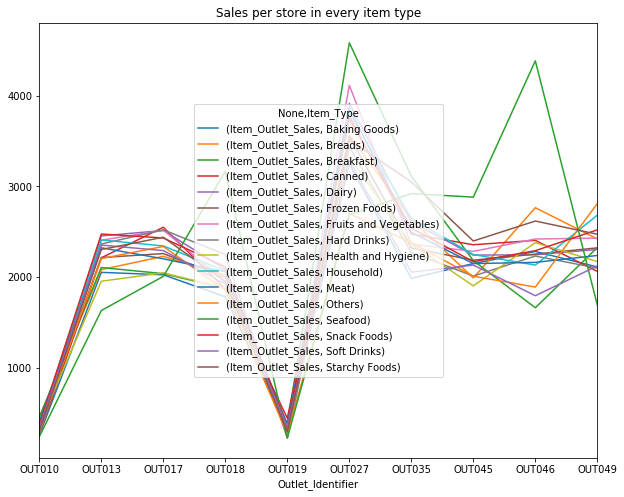

In [21]:
item_type_table.plot(figsize=(10,8),title='Sales per store in every item type')
# Sales were highest in store #OUT027 and #OUT046 whereas they were lowest in OUT010

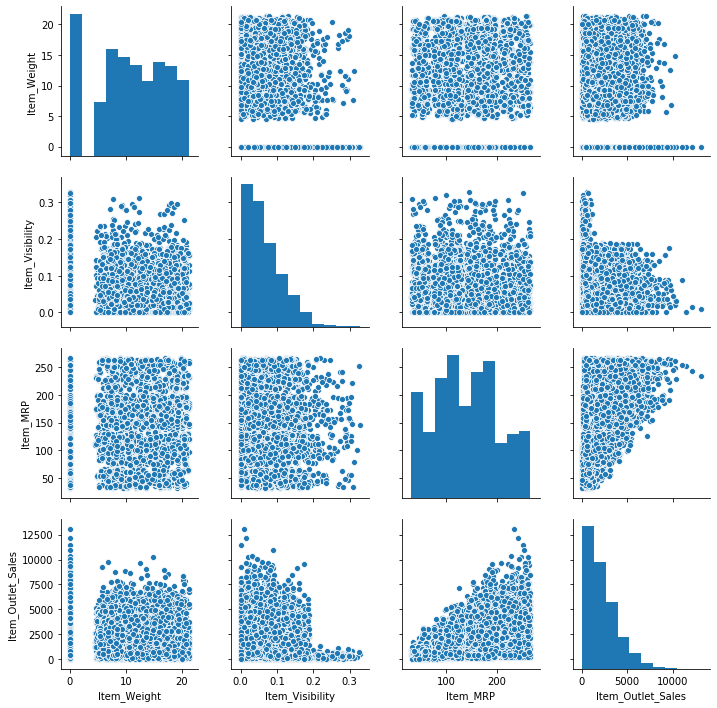

In [15]:
# relationship between variables
sns.pairplot(mart.loc[:,mart.dtypes == 'float64'])

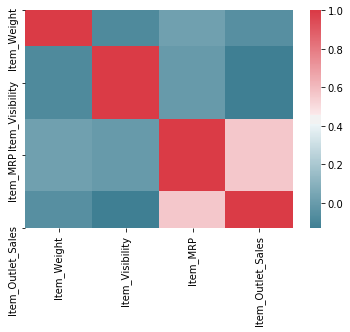

In [18]:
# Correlation among variables
corr = mart.loc[:,mart.dtypes == 'float64'].corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap=sns.diverging_palette(220, 10, as_cmap=True))
# Sales is positively correlated with item MRP 

#### Prediction

In [170]:
train = mart
train_cols = list(train.columns)
train_item_identifier = train["Item_Identifier"]
train = train.drop(['Outlet_Establishment_Year'],axis=1)
train.loc[train['Item_Fat_Content'] == 'Regular', 'Item_Fat_Content'] = 'reg'
train.loc[train['Item_Fat_Content'] == 'Low Fat', 'Item_Fat_Content'] = 'LF'
train.loc[train['Item_Fat_Content'] == 'low fat', 'Item_Fat_Content'] = 'LF'

In [171]:
train['Item_Fat_Content'].unique()

array(['LF', 'reg'], dtype=object)

In [172]:
test = pd.read_csv("./BigMart3_Test.csv") 
test_cols = list(test.columns)
test_item_identifier = test["Item_Identifier"]
test = test.drop(['Outlet_Establishment_Year'],axis=1)
test.loc[test['Item_Fat_Content'] == 'Regular', 'Item_Fat_Content'] = 'reg'
test.loc[test['Item_Fat_Content'] == 'Low Fat', 'Item_Fat_Content'] = 'LF'
test.loc[test['Item_Fat_Content'] == 'low fat', 'Item_Fat_Content'] = 'LF'
test["Outlet_Size"].fillna("NULL", inplace=True)
test["Item_Weight"].fillna(0, inplace=True)

In [173]:
train.columns, train.shape, test.columns, test.shape

(Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
        'Item_Type', 'Item_MRP', 'Outlet_Identifier', 'Outlet_Size',
        'Outlet_Location_Type', 'Outlet_Type', 'Item_Outlet_Sales'],
       dtype='object'),
 (8523, 11),
 Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
        'Item_Type', 'Item_MRP', 'Outlet_Identifier', 'Outlet_Size',
        'Outlet_Location_Type', 'Outlet_Type'],
       dtype='object'),
 (5681, 10))

In [174]:
# One hot encoding categorical variables
train_onehot = pd.get_dummies(train, prefix_sep="__",columns=list(Counter(train_cols)-Counter(numerical)-Counter(['Item_Identifier']).keys()))
test_onehot = pd.get_dummies(test, prefix_sep="__",columns=list(Counter(test_cols)-Counter(numerical)-Counter(['Item_Identifier']).keys()))

In [175]:
train_onehot = train_onehot.drop(["Item_Identifier"],axis = 1)
test_onehot = test_onehot.drop(["Item_Identifier"],axis = 1)

In [176]:
from sklearn.model_selection import train_test_split
# Drop target variable from train dataset
X = train_onehot.drop(["Item_Outlet_Sales"],axis = 1)
y = train_onehot["Item_Outlet_Sales"]
X.shape, y.shape

((8523, 42), (8523,))

In [177]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6818, 42), (1705, 42), (6818,), (1705,))

In [189]:
# Standardize dataset
scaler = StandardScaler()
trainScaled = scaler.fit_transform(X_train)
testScaled = scaler.transform(X_test)

In [184]:
numerical.remove('Outlet_Establishment_Year')
numerical.remove('Item_Outlet_Sales')

In [190]:
model = LinearRegression()
model.fit(trainScaled, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [192]:
# Evaluation - Mean Squared Error and Mean Absolute Error
mse = mean_squared_error(y_train, model.predict(trainScaled))
mae = mean_absolute_error(y_train, model.predict(trainScaled))
print("mse = ",mse," & mae = ",mae," & rmse = ", sqrt(mse))
test_mse = mean_squared_error(y_test, model.predict(testScaled))
test_mae = mean_absolute_error(y_test, model.predict(testScaled))
print("mse = ",test_mse," & mae = ",test_mae," & rmse = ", sqrt(test_mse))

mse =  1279865.9805091196  & mae =  837.990611641879  & rmse =  1131.3116195412824
mse =  1240793.6100214217  & mae =  834.5854908263245  & rmse =  1113.9091569878676
